In [1]:
!pip install pyAudioAnalysis eyed3 pydub hmmlearn

In [2]:
from pyAudioAnalysis import ShortTermFeatures
from scipy.io import wavfile
import matplotlib.pyplot as plt
import scipy
import numpy as np

In [3]:
fs, data = wavfile.read('./dry3.wav')

It returns a tuple of two items: the first is the sampling rate in samples per second, the second is a numpy array with all the data read from the file

Sometimes there are two columns in data because there are two channels.

In [4]:
print('The sampling frequency is %d Hz' % fs)

The sampling frequency is 44100 Hz


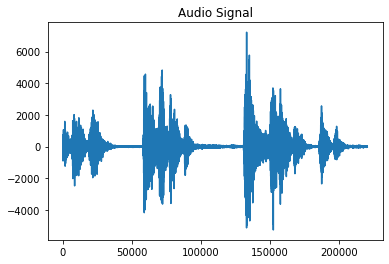

In [5]:
plt.plot(data)
plt.title('Audio Signal')
plt.show()

Let's check the spectrogram (just for fun)

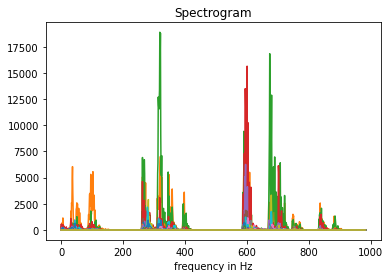

In [6]:
f,t,Sxx = scipy.signal.spectrogram(data,fs)

plt.plot(Sxx.transpose())
plt.title('Spectrogram')
plt.xlabel('frequency in Hz')
plt.show()

###First approch to split the cough

In [7]:
from pyAudioAnalysis import audioSegmentation as aS

First we try an already implemented function : ```silence_removal```



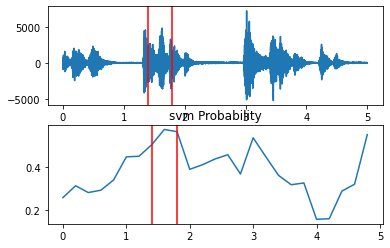

In [8]:
segments = aS.silence_removal(data, fs, 0.040, 0.20, smooth_window = 1.0, weight = 0.75, plot = True)

It doesn't work well : let's dry to change the parameters ````st_size```` and ````st_step````

st_step = 0.015


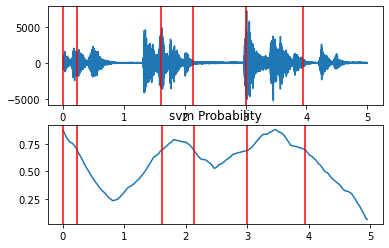

st_step = 0.016


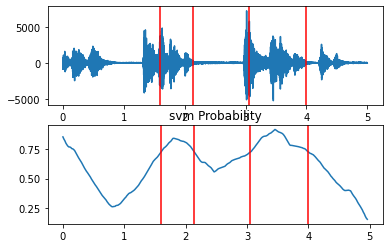

st_step = 0.017


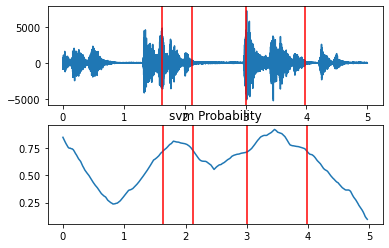

st_step = 0.018


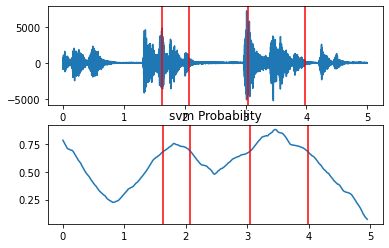

st_step = 0.019


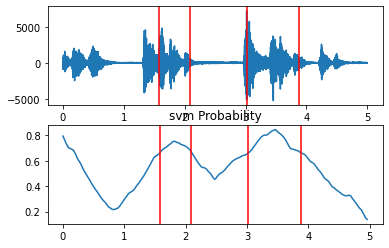

In [9]:
windows_step = np.linspace(0.015,0.019,5)
for st_step in windows_step :
  print('st_step = '+str(st_step))
  segments = aS.silence_removal(data, fs, 0.040, st_step, smooth_window = 1.0, weight = 0.75, plot = True)

Still not working... Let's try something else

# Sliding window

We are going to use a sliding window to detect the begining and the end of every cough

In [10]:
def find_extremities(signal,window_size, start_thresh, end_thresh):
    starting_ind = []
    ending_ind = []
    c=0
    for i in range(len(signal)-window_size):
        window_mean = np.mean(np.abs(signal[i:i+window_size]))
        if len(starting_ind)-len(ending_ind) == 0 and window_mean > start_thresh :
            starting_ind.append(i)
            c=i
        elif len(starting_ind)-len(ending_ind) == 1 and window_mean < end_thresh and i-c>window_size :
            ending_ind.append(i+window_size)
    return starting_ind,ending_ind

In [11]:
def plot_cut_sig(signal,extremities):
    plt.figure(figsize=(20,12))
    plt.plot(signal)
    for start in extremities[0]:
        plt.axvline(x=start,color='g')
    for end in extremities[1]:
        plt.axvline(x=end,color='r')
    plt.show()

We can find good parameters for a cough which won't work for another cough.
So first of all we can select by hand the best parameters ```window_size, start_thresh, end_thresh``` for each cough, then draw a table. ![](https://octobuz.hyris.tv/~coeurtiov/excel)

We can notice that the ratio $\frac{\text{Start Threshold}}{\text{Amplitude}}$ is around 9, the ratio $\frac{\text{End Threshold}}{\text{Amplitude}}$ is around 3 and $\text{window time} = \frac{\text{window size}}{f_s} \simeq 20 \text{ ms}$.

So now, we can define ``` window_size = int(0.05*fs)``` ,```start_thresh = 0.09*amplitude``` and ```end_thres = 0.03*amplitude```. It will work with the majority of audios !

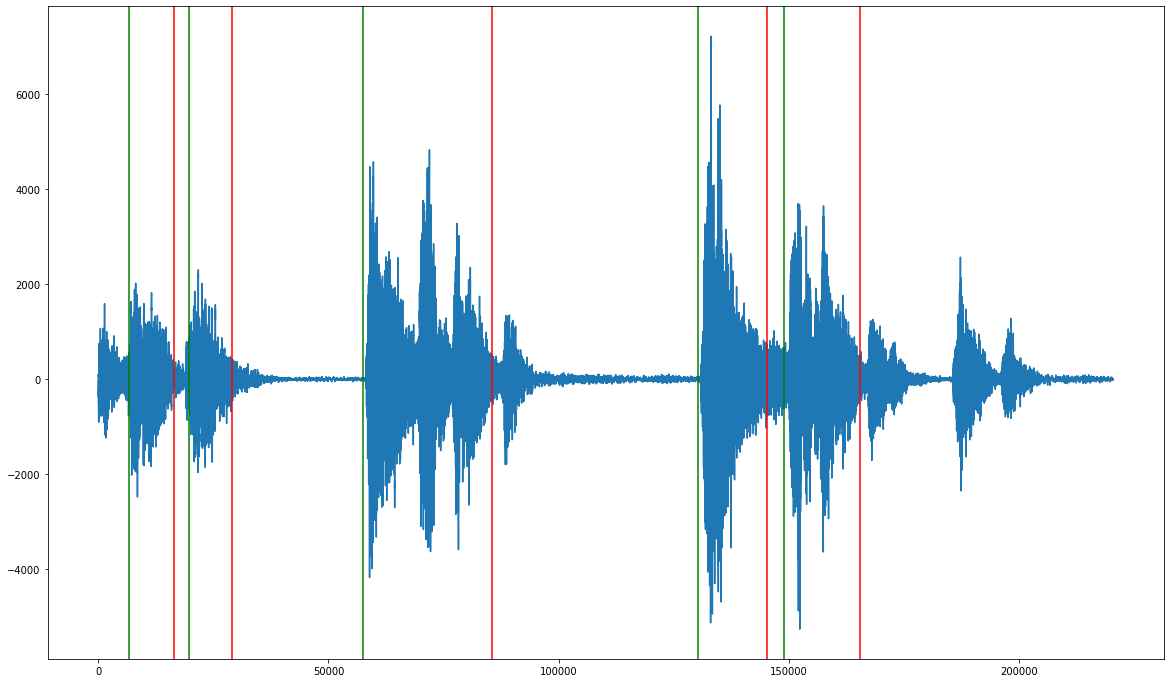

In [12]:
amplitude = np.max(np.abs(data))

ex = find_extremities( data , int(0.05*fs) , 0.09*amplitude , 0.03*amplitude )
plot_cut_sig(data,ex)

It works well ! The function ```plot_cut_sig``` returns a tuple with the beginnings and ends of each cough. 

In [13]:
print(ex)

([6714, 19770, 57541, 130388, 149054], [16532, 29006, 85602, 145402, 165506])


Now we can separate the coughs

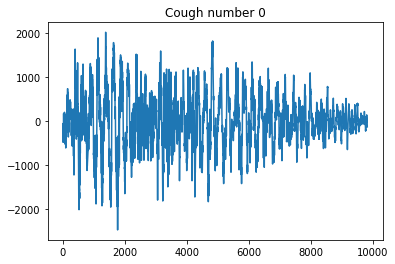

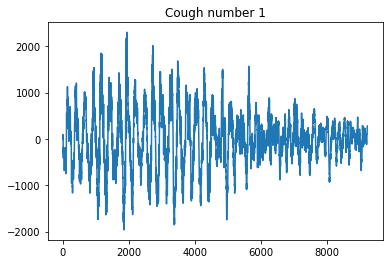

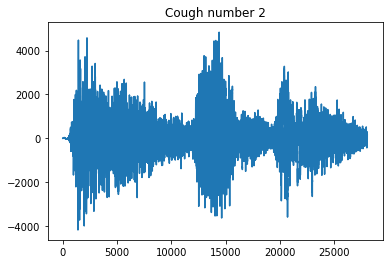

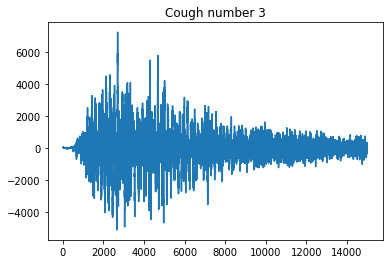

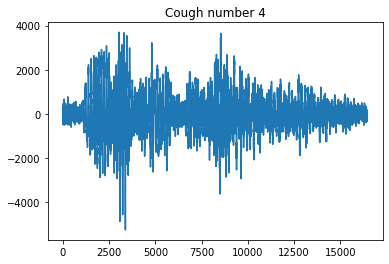

In [14]:
number_of_cough = len(ex[0])
for i in range(number_of_cough):
  beg = ex[0][i]
  end = ex[1][i]
  plt.plot(data[beg:end])
  plt.title('Cough number '+str(i))
  plt.show()